# Preamble

## import

In [18]:
import os

import numpy as np
from scipy.linalg import block_diag

import nengo
from nengo.params import Default, NumberParam
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.neurons import *
from nengo.builder.neurons import *

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import Highpass, Lowpass

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='dark', style='whitegrid')
%matplotlib inline

## utilities

In [2]:
def norms(signal, freq, amp, ss, tau, t, dt=0.001, plot=False):
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(period=t/2, high=freq, rms=amp, seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt, y0=0)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    if plot:
        plt.plot(sim.trange(), stimulus, label='stim', alpha=0.5)
        plt.plot(sim.trange(), target, label='integral', alpha=0.5)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f, dt=dt), label='target', alpha=0.5, y0=0)
        plt.legend()
        plt.show()
    return norm, norm_s, norm_f

In [3]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

# Wilson Neuron

In [4]:
class WilsonNeuron(NeuronType):
    """
    Wilson Neuron Model.
    
    Description
    -----------
    
    TODO
    
    Paramters
    ---------

    TODO
    
    References
    ----------
    [1] Wilson, Hugh R. "Simplified dynamics of human and mammalian neocortical neurons."
        Journal of theoretical biology 200.4 (1999): 375-388.

    
    """
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonNeuron, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args


    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        J_steps = 201  # Odd number so that 0 is a sample
        max_rate = max_rates.max()

        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0
        for _ in range(10):
            J = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
#             print('rate', rate)
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= 2
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")

        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain

        return gain, bias

    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)
        AP = np.zeros_like(J, dtype=bool)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance, AP],
            dt=0.00005, settle_time=0.1, sim_time=1.0)


    def step_math(self, dt, J, spiked, V, R, H, AP):
        if np.abs(J).any() >= 2.0:
            warnings.warn("input current exceeds failure point; clipping")
            J = J.clip(max=self._maxJ)

        dV = -(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) - 26*R*(V + 0.95) - 13*H*(V + 0.95) + J
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        
        V[:] = (V + dV * dt/self.tau_V).clip(-0.9, 0.3)
        R[:] = (R + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        H[:] = (H + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (V > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = V > self.threshold
        
        return spiked, V, R, H, AP


@Builder.register(WilsonNeuron)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

In [5]:
class WilsonRK4(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonRK4, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
        # TODO(arvoelke): Try replacing this solver with something like
        # http://www2.gsu.edu/~matrhc/PyDSTool.htm
        # The main consideration is that we need a callback to count spikes
        from scipy.integrate import ode
        self.solver = ode(self._ode_fun).set_integrator(
            'dopri5', first_step=0.00005, nsteps=100,
            rtol=1e-2, atol=1e-3)  # runge-kutta method of order (4)5
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance],
            dt=0.001, settle_time=0.1, sim_time=1.0)

    def _ode_fun(self, dummy_t, y, J):  # first argument to scipy.integrate.ode
        V, R, H = np.split(y, 3)
        dV = (-(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) -
              26*R*(V + 0.95) - 13*H*(V + 0.95) + J)
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        return np.concatenate((
            dV / self.tau_V, dR / self.tau_R, dH / self.tau_H))

    def step_math(self, dt, J, spiked, V, R, H):
        # It's a little silly to be reinitializing the solver on
        # every time-step, but any other ways that I could think of would 
        # violate the nengo builder's assumption that the neuron's state is
        # encapsulated by the signals in SimNeurons
        self.solver.set_initial_value(np.concatenate((V, R, H)))
        self.solver.set_f_params(J.clip(max=self._maxJ))
        
        spiked[:] = 0
        AP = V > self.threshold
        def spike_detector(dummy_t, y):  # callback for each sub-step
            V_t = y[:len(V)] > self.threshold
            spiked[:] += V_t & (~AP)  # note the "+="
            AP[:] = V_t
        self.solver.set_solout(spike_detector)

        V[:], R[:], H[:] = np.split(self.solver.integrate(self.solver.t + dt), 3)
        if not self.solver.successful():
            raise ValueError("ODE solver failed with status code: %d" % (
                self.solver.get_return_code()))
        spiked[:] /= dt

        return spiked, V, R, H


@Builder.register(WilsonRK4)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['recovery'],
                model.sig[neurons]['conductance']]))

# Network

In [6]:
def simulate(  
    d_pre,
    d_supv,
    d_fb,
    h,
    t=1,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    signal='cos',
    freq=1,
    amp=1,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=nengo.LIF(),
    gain=Default,
    bias=Default,
    max_rates=Default,
    intercepts=Default,
    **kwargs):
    
    if np.count_nonzero(d_pre) == 0:
        neuron_type = nengo.LIF()
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t, dt=dt, plot=False)
    
    # Simulate the full network, skipping simulation of supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:

        # Nodes
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        if signal == 'cos':
            u_raw = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            u_raw = nengo.Node(nengo.processes.WhiteSignal(period=model.T/2, high=freq, rms=amp, seed=seeds['ss']))
        u = nengo.Node(output=flip, size_in=1)
                                              
        # Ensembles
        pre_u = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm_s)
        pre_x = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm)
        supv = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='supv')
        fb = nengo.Ensemble(n_neurons, 1,
            gain=gain, bias=bias,
            max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='fb')
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        lif_ideal = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # normal connections
        nengo.Connection(u_raw, u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])  # transform=1.0/norm_f, 
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
        nengo.Connection(lif, lif, synapse=taus['network'])
        
        # supervised connections
        nengo.Connection(pre_u, supv, synapse=taus['network'],
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(pre_x, supv, synapse=taus['network'], # seed=seeds['cs'])
            solver=NoSolver(d_pre), seed=seeds['cs'])
        
        # feedback connections
        nengo.Connection(pre_u, fb, synapse=taus['network'],
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(fb, fb, synapse=h,
            solver=NoSolver(d_fb), seed=seeds['cs'])

        # probes
        p_stim = nengo.Probe(u, synapse=None, sample_every=dt)
        p_target = nengo.Probe(tar, synapse=None, sample_every=dt)
        p_spk_pre = nengo.Probe(pre_x.neurons, synapse=None, sample_every=dt)
        p_spk_supv = nengo.Probe(supv.neurons, synapse=None, sample_every=dt)
        p_spk_fb = nengo.Probe(fb.neurons, synapse=None, sample_every=dt)
        p_spk_lif = nengo.Probe(lif.neurons, synapse=None, sample_every=dt)
        p_lif = nengo.Probe(lif, synapse=taus['readout'], sample_every=dt)
        

    # Run the simulation
    with nengo.Simulator(model, seed=seeds['ss'], dt=dt, progress_bar=True) as sim:
        sim.run(t, progress_bar=True)
        
    return dict(
#         trange=sim.trange(sample_every=dt),
        stim=1.0/norm_f*sim.data[p_stim],  # apply transform to agree with tar
        tar=sim.data[p_target],
        spk_pre=sim.data[p_spk_pre],
        spk_supv=sim.data[p_spk_supv],
        spk_fb=sim.data[p_spk_fb],
        spk_lif=sim.data[p_spk_lif],
        x_lif=sim.data[p_lif])

## Decoder and Filter Updates

In [7]:
def update_d(target_data, spk_data, h, **kwargs):
    lpf = nengo.Lowpass(kwargs['taus']['readout'])
    target = lpf.filt(target_data, dt=kwargs['dt'], y0=0)
    A = h.filt(spk_data, dt=kwargs['dt'], y0=0)
    d_new = LstsqL2(reg=kwargs['lambda_d'])(A, target)[0]
    return d_new

In [40]:
def update_h(stim_data, target_data, spk_data, min_tau=0.001, max_tau=1.0, **kwargs):

    """Return n samples (taus) from the prior of a k'th-order synapse."""
    order = kwargs['order']
    n_samples = kwargs['n_samples']
    rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
    taus = rng.uniform(min_tau, max_tau, size=(n_samples, order))

    poles = -1. / taus
    n_steps = spk_data.shape[0]
    n_neurons = spk_data.shape[1]
    assert poles.shape == (n_samples, order)
    
    tf_params = np.zeros((n_samples, order))
    for i in range(n_samples):
        sys = LinearSystem(([], poles[i, :], 1 / np.prod(taus[i, :])))   # (zeros, poles, gain)
        assert len(sys) == order
        assert np.allclose(sys.dcgain, 1)
        den_normalized = np.asarray(sys.den / sys.num[0])
        assert len(den_normalized) == order + 1
        assert np.allclose(den_normalized[-1], 1)  # since normalized
        # tf_params ordered from lowest to highest, ignoring c_0 = 1, i.e., [c_1, ..., c_k]
        tf_params[i, :] = den_normalized[:-1][::-1]

    # We assume c_i are independent by setting the off-diagonals to zero
    C = np.cov(tf_params, rowvar=False)
    if order == 1:
        C = C*np.eye(1)
    Q = np.linalg.inv(C)
    c0 = np.mean(tf_params, axis=0)
    d0 = np.ones((n_neurons, ))
    cd0 = np.hstack((c0, d0))
    assert Q.shape == (order, order)
    assert cd0.shape == (order+n_neurons,)

    diff = (1. - ~z) / kwargs['dt']
    A = np.zeros((n_steps, order + n_neurons))
    deriv_n = target_data
    for i in range(order):
        deriv_n = diff.filt(deriv_n, y0=0, dt=kwargs['dt'])
        A[:, i] = deriv_n.ravel()  # todo: D>1
    for n in range(n_neurons):
        A[:, order+n] = spk_data[:, n]
    b = kwargs['taus']['network']  # set on pre_u ==> supv connection in network
    Y = (b*stim_data - target_data)
    smoother = Lowpass(kwargs['taus']['readout'])
    A = smoother.filt(A, y0=0, dt=kwargs['dt'], axis=0)
    Y = smoother.filt(Y, y0=0, dt=kwargs['dt'])
    
    # construct block diagonal matrix with different regularizations for filter coefficients and decoders
    L = block_diag(kwargs['lambda_c']*Q, kwargs['lambda_d']*np.eye(n_neurons))
    gamma = A.T.dot(A) + L
    upsilon = A.T.dot(Y) + L.dot(cd0).reshape((order+n_neurons, 1))  # optional term with tikhonov regularization
    
    cd = np.linalg.inv(gamma).dot(upsilon).ravel()
    c_new = cd[:order]
    d_new = -1.*cd[-n_neurons:]
    assert c_new.shape==(order,)
    assert d_new.shape==(n_neurons,)
    d_new = d_new.reshape((n_neurons, 1))
    h_new = 1. / (1 + sum(c_new[i] * s**(i+1) for i in range(order)))
    act = h_new.filt(spk_data, y0=0, dt=kwargs['dt'])
    xhat = np.dot(act, d_new)
    tar = Lowpass(kwargs['taus']['readout']).filt(target_data, y0=0, dt=kwargs['dt'])
    error = nrmse(xhat.reshape((xhat.shape[0], 1)), target=tar)  # todo: D>1
    assert np.allclose(h_new.dcgain, 1)
    print('c_new', c_new)

    return h_new, d_new

## Plotting

In [32]:
def get_nrmse(datadict, d_supv, d_fb, h, **kwargs):
    dt = kwargs['dt']
    lpf = Lowpass(kwargs['taus']['readout'])
    A_pre = lpf.filt(datadict['spk_pre'], dt=dt, y0=0)
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt, y0=0)
    A_supv = h.filt(datadict['spk_supv'], dt=dt, y0=0)
    A_fb = h.filt(datadict['spk_fb'], dt=dt, y0=0)
    target = lpf.filt(datadict['tar'], dt=dt, y0=0)
    xhat_lif = datadict['x_lif']
    nrmse_lif = nrmse(xhat_lif, target=target)
    xhat_fb = np.dot(A_fb, d_fb)
    nrmse_fb = nrmse(xhat_fb, target=target)
    return nrmse_lif, nrmse_fb

In [33]:
def make_plots(datadict, d_supv, d_fb, h,
        plot_tuning=False, plot_filter=False, plot_estimate=False, **kwargs):

    dt = kwargs['dt']
    dt_sample = kwargs['dt_sample']
    n_neurons = kwargs['n_neurons']
    taus = kwargs['taus']
    lpf = Lowpass(taus['readout'])
    A_pre = lpf.filt(datadict['spk_pre'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_supv = h.filt(datadict['spk_supv'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_fb = h.filt(datadict['spk_fb'], dt=dt, y0=0)[::int(dt_sample/dt)]
    target = lpf.filt(datadict['tar'], dt=dt, y0=0)[::int(dt_sample/dt)]
    times = dt_sample * np.arange(0, len(target), 1)
    cmap = sns.color_palette('hls', 10)

    xhat_lif = datadict['x_lif'][::int(dt_sample/dt)]
    nrmse_lif = nrmse(xhat_lif, target=target)
    xhat_supv = np.dot(A_supv, d_supv)
    nrmse_supv = nrmse(xhat_supv, target=target)
    xhat_fb = np.dot(A_fb, d_fb)
    nrmse_fb = nrmse(xhat_fb, target=target)
    
    x_bins_pre, hz_means_pre, hz_stds_pre = bin_activities_values_1d(
        target, A_pre, n_neurons=n_neurons)
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
        target, A_lif, n_neurons=n_neurons)
    x_bins_supv, hz_means_supv, hz_stds_supv = bin_activities_values_1d(
        target, A_supv, n_neurons=n_neurons)
    x_bins_fb, hz_means_fb, hz_stds_fb = bin_activities_values_1d(
        target, A_fb, n_neurons=n_neurons)

    if plot_filter:
        impulse_time = np.arange(0, 1, 0.001)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(impulse_time, Lowpass(taus['readout']).impulse(len(impulse_time)), label='lowpass')
        ax.plot(impulse_time, h.impulse(len(impulse_time)), label='optimized')
        ax.set(xlabel='time (s)', ylabel='amplitude')
        ax.legend()
        plt.tight_layout()
        plt.show()

    if plot_tuning:
        a_error_supv = np.average(np.abs(A_supv - A_lif))
        a_error_fb = np.average(np.abs(A_fb - A_lif))
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
        for n in range(10):  # n_neurons
            ax1.plot(x_bins_pre, hz_means_pre[n], c=cmap[n])
            ax1.fill_between(x_bins_pre,
                hz_means_pre[n]+hz_stds_pre[n],
                hz_means_pre[n]-hz_stds_pre[n],
                alpha=0.5, facecolor=cmap[n])
            ax2.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax2.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax3.plot(x_bins_supv, hz_means_supv[n], c=cmap[n])
            ax3.fill_between(x_bins_supv,
                hz_means_supv[n]+hz_stds_supv[n],
                hz_means_supv[n]-hz_stds_supv[n],
                alpha=0.5, facecolor=cmap[n])
            ax4.plot(x_bins_fb, hz_means_fb[n], c=cmap[n])
            ax4.fill_between(x_bins_fb,
                hz_means_fb[n]+hz_stds_fb[n],
                hz_means_fb[n]-hz_stds_fb[n],
                alpha=0.5, facecolor=cmap[n])
        ax1.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='pre_x')
        ax2.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='lif')
        ax3.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='supv \n %s \n rmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], a_error_supv))
        ax4.set(xlim=((-1,1)), xlabel='$\mathbf{x}$', title='fb \n %s \n rmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], a_error_fb))
        plt.tight_layout()

    if plot_estimate:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(times, target, label='target', linestyle='--')
        ax.plot(times, xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(times, xhat_supv, alpha=0.5, label='supv, %s, nrmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], nrmse_supv))
        ax.plot(times, xhat_fb, alpha=0.5, label='fb, %s, nrmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], nrmse_fb))
        ax.set(xlabel='time', ylabel='$\mathbf{x}$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.show()
        
    return nrmse_lif, nrmse_fb

## Control Structure

In [34]:
def run(optimize_h=False, **kwargs):
    
    rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
    d_pre = np.zeros((kwargs['n_neurons'], 1))
    d_supv = np.zeros((kwargs['n_neurons'], 1))
    d_fb = np.zeros((kwargs['n_neurons'], 1))
    h = Lowpass(kwargs['taus']['readout'])
    dt_set = kwargs['dt']
    dt_sample_set = kwargs['dt_sample']
       
    print("oracle method to compute decoders for pre_x => supv")
    kwargs['dt'] = 0.001
    kwargs['dt_sample'] = 0.001
    datadict1 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    d_pre = update_d(datadict1['tar'], datadict1['spk_pre'], h, **kwargs)
#     make_plots(datadict1, d_supv, d_fb, h, **kwargs)

    print("oracle method to compute readout decoders for supv")
    kwargs['dt'] = dt_set
    kwargs['dt_sample'] = dt_sample_set
    datadict2 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    d_supv = update_d(datadict2['tar'], datadict2['spk_supv'], h, **kwargs)
#     make_plots(datadict2, d_supv, d_fb, h, plot_tuning=True, plot_estimate=True, **kwargs)
    
    print("least-squares optimization of recurrent filter and decoders for fb")
    h, d_fb = update_h(datadict2['stim'], datadict2['tar'], datadict2['spk_supv'], **kwargs)
    make_plots(datadict2, d_supv, d_fb, h, plot_filter=True, **kwargs)

    print("testing (no supervision)")
    kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
    kwargs['signal'] = 'white_noise'
    datadict3 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
    make_plots(datadict3, d_supv, d_fb, h, plot_estimate=True, plot_tuning=True, **kwargs)
   
    return d_pre, d_supv, d_fb, h

In [35]:
def run_trials_types(n_trials, **kwargs):
    
    neuron_types = [nengo.LIF(), nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1)]  # , WilsonRK4()
    nrmses = np.zeros((n_trials, 4))
    
    for nt, neuron_type in enumerate(neuron_types):
        print("neuron_type = %s" %neuron_type)
        kwargs['neuron_type'] = neuron_type
        rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
        d_pre = np.zeros((kwargs['n_neurons'], 1))
        d_supv = np.zeros((kwargs['n_neurons'], 1))
        d_fb = np.zeros((kwargs['n_neurons'], 1))
        h = Lowpass(kwargs['taus']['readout'])
        dt_set = kwargs['dt']
        dt_sample_set = kwargs['dt_sample']

        print("oracle method to compute decoders for pre_x => supv")
        kwargs['dt'] = 0.001
        kwargs['dt_sample'] = 0.001
        datadict1 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
        d_pre = update_d(datadict1['tar'], datadict1['spk_pre'], h, **kwargs)

        print("oracle method to compute readout decoders for supv")
        kwargs['dt'] = dt_set
        kwargs['dt_sample'] = dt_sample_set
        datadict2 = simulate(d_pre, d_supv, d_fb, h, **kwargs)
        d_supv = update_d(datadict2['tar'], datadict2['spk_supv'], h, **kwargs)

        print("least-squares optimization of recurrent filter and decoders for fb")
        h, d_fb = update_h(datadict2['stim'], datadict2['tar'], datadict2['spk_supv'], **kwargs)
        make_plots(datadict2, d_supv, d_fb, h, plot_filter=True, **kwargs)

        print("testing")
        for j in range(n_trials):
            print("trial %s" %j)
            kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
            datadict_test = simulate(d_pre, d_supv, d_fb, h, **kwargs)
            nrmse_lif, nrmse_fb = get_nrmse(datadict_test, d_supv, d_fb, h, **kwargs)
            make_plots(datadict_test, d_supv, d_fb, h, plot_estimates=True, **kwargs)
            nrmses[j, 0] = nrmse_lif
            nrmses[j, nt+1] = nrmse_fb

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.barplot(data=nrmses)
    ax.set(xlabel='neuron_type', ylabel='nrmse')
    plt.xticks(np.arange(4), ('default', 'LIF', 'ALIF', 'Wilson'))
    plt.show()

# Simulations

## LIF

oracle method to compute decoders for pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


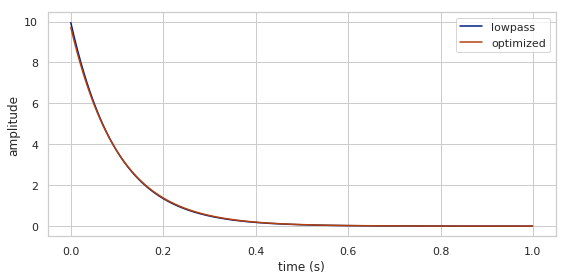

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

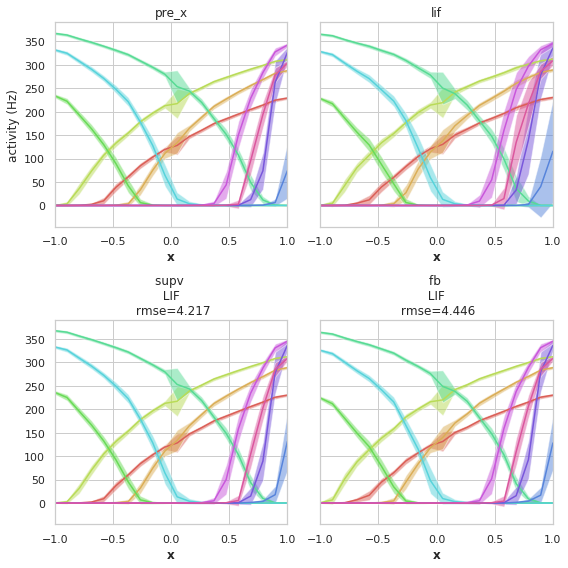

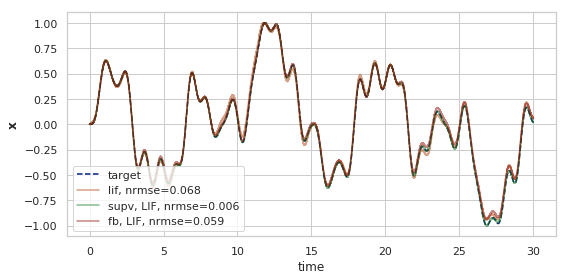

In [36]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-3,
    order=1,
    n_samples=10000,
    signal='white_noise')

d_pre, d_supv, d_fb, h = run(**kwargs)

oracle method to compute decoders for pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[-0.]], B=[[1.]], C=[[-1000.]], D=[[1000.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


c_new [0.10241943 0.00012457]


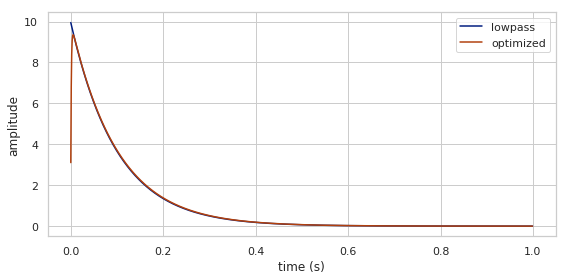

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

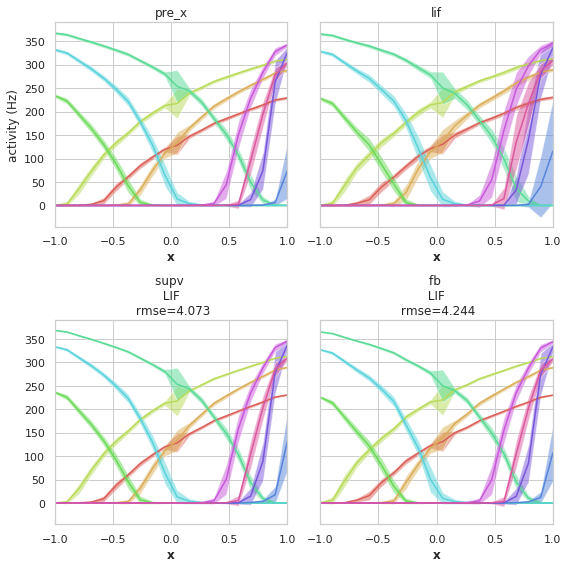

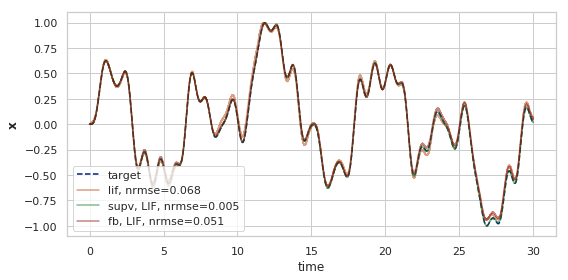

In [42]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-3,
    order=2,
    n_samples=10000,
    signal='white_noise')

d_pre, d_supv, d_fb, h = run(**kwargs)

oracle method to compute decoders for pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[-0.]], B=[[1.]], C=[[-1000.]], D=[[1000.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


c_new [1.02571065e-01 9.46834017e-05 1.28930764e-07]


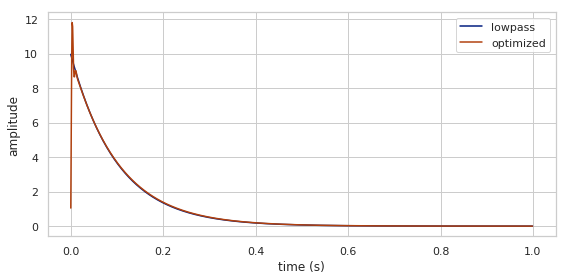

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

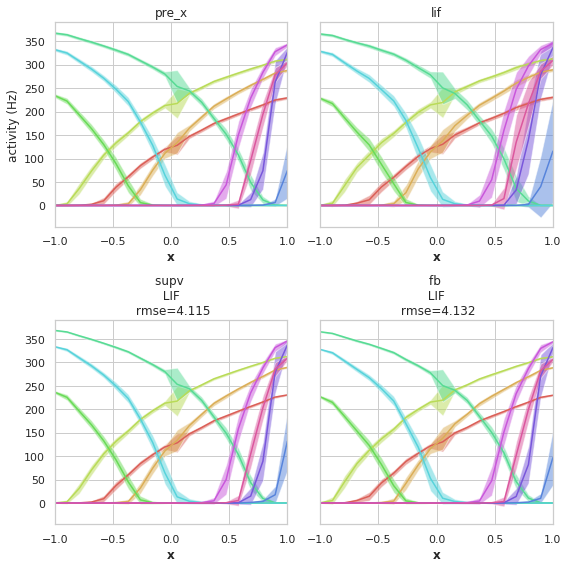

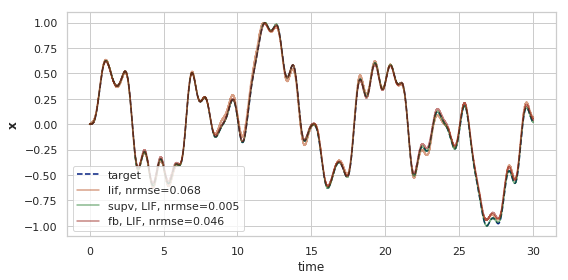

In [43]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-2,
    order=3,
    n_samples=10000,
    signal='white_noise')

d_pre, d_supv, d_fb, h = run(**kwargs)

## ALIF

oracle method to compute decoders for pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


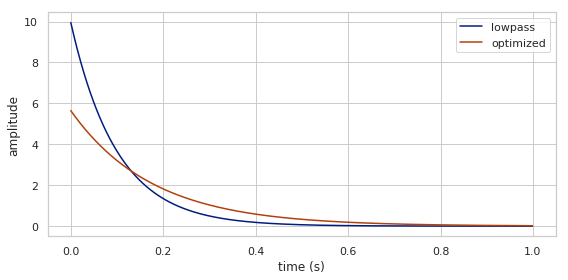

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

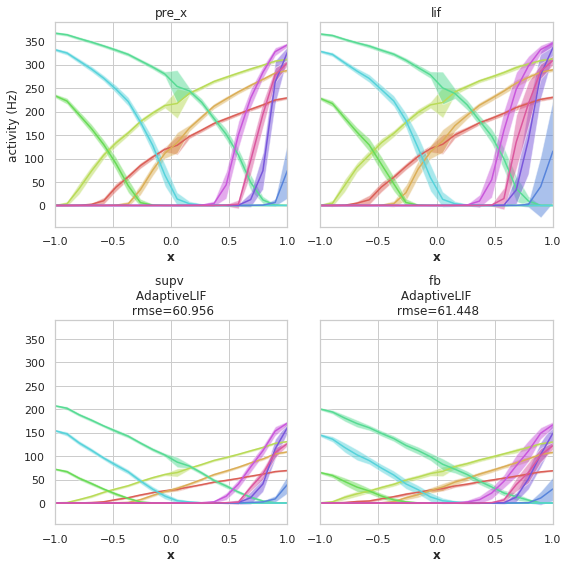

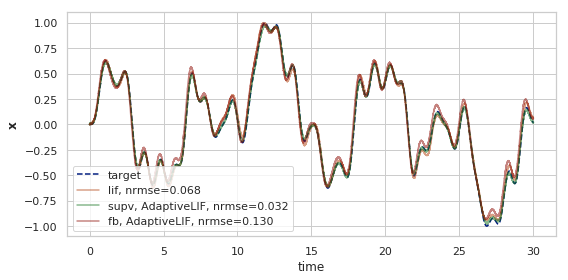

In [37]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-3,
    order=1,
    n_samples=10000,
    signal='white_noise')

d_pre, d_supv, d_fb, h = run(**kwargs)

oracle method to compute decoders for pre_x => supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[-0.]], B=[[1.]], C=[[-1000.]], D=[[1000.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/nengo/nengo/utils/numpy.py:164: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean(x**2, axis=axis, keepdims=keepdims))
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


c_new [ 0.17705767 -0.00121983]


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


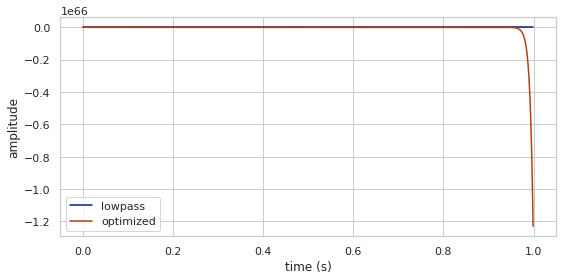

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

FloatingPointError: invalid value encountered in multiply

In [41]:
kwargs = dict(
    t=30,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=1,
    amp=1,
    max_rates=Default,
    intercepts=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-2,
    order=2,
    n_samples=10000,
    signal='white_noise')

d_pre, d_supv, d_fb, h = run(**kwargs)